In [4]:
%matplotlib inline

from pathlib import Path

import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
figsize(12, 12)


import geopandas as gpd
import pandas as pd
import rasterio as rio

from rasterio import plot as rio_plot

# HRSL Spike

**Note: This data is all compressed on S3 so you will need to unzip both the GADM data (shapefiles of political boundaries) and the HRSL data (raster grids of population) before running this notebook.**

 - Load Admin2 boundaries from GADM
 - Select Rawanda as a test case
 - plot the boundaries
 - plot all the data
 - Calculate the sum per admin area using `zonal_stats`
 - plot the calculated populations
 

### Load GADM boundaries

In [5]:
boundaries = gpd.read_file(str(Path('../data/external/gadm28_levels.shp/gadm28_adm2.shp')))

In [6]:
rwa_admin_2 = boundaries[boundaries.ISO == 'RWA']

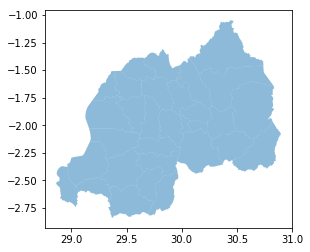

In [7]:
rwa_admin_2.plot(alpha=0.5)
figsize(12, 12)


### Load HRSL data

In [8]:
rwa_hrsl_path = str(Path("../data/external/HRSL/rwa/hrsl_rwa.tif"))
rst = rio.open(rwa_hrsl_path)

In [9]:
import numpy as np
figsize(200, 200)

rio_plot.show(rst, cmap=plt.cm.magma)
figsize(12, 12)

### Calculate sum of population for each admin area

/Users/bull/anaconda3/envs/subnational-vaccines/lib/python3.6/site-packages/rasterstats/main.py:145: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  with Raster(raster, affine, nodata, band) as rast:
/Users/bull/anaconda3/envs/subnational-vaccines/lib/python3.6/site-packages/rasterstats/io.py:242: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  self.affine = guard_transform(self.src.transform)
/Users/bull/anaconda3/envs/subnational-vaccines/lib/python3.6/site-packages/rasterstats/main.py:165: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  np.issubdtype(fsrc.array.dtype, float)
/Users/bull/anaconda3/envs/subnational-vaccines/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is try

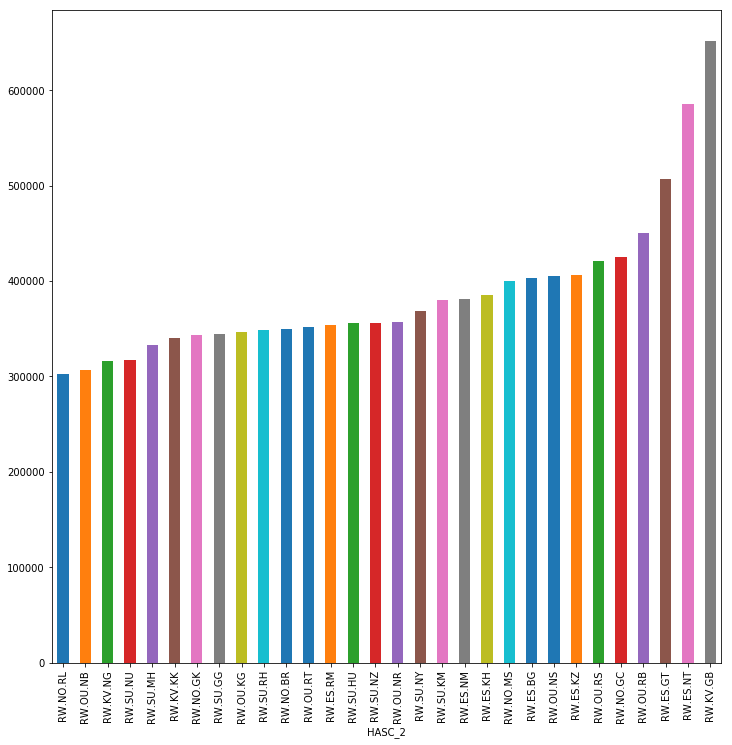

In [10]:
import rasterstats as rs

pop_list = rs.zonal_stats(rwa_admin_2, rwa_hrsl_path, stats='sum')
rwa_admin_2['hrsl_pop'] = [x['sum'] for x in pop_list]

(rwa_admin_2.set_index('HASC_2')
            .hrsl_pop
            .sort_values()
            .plot(kind='bar'))

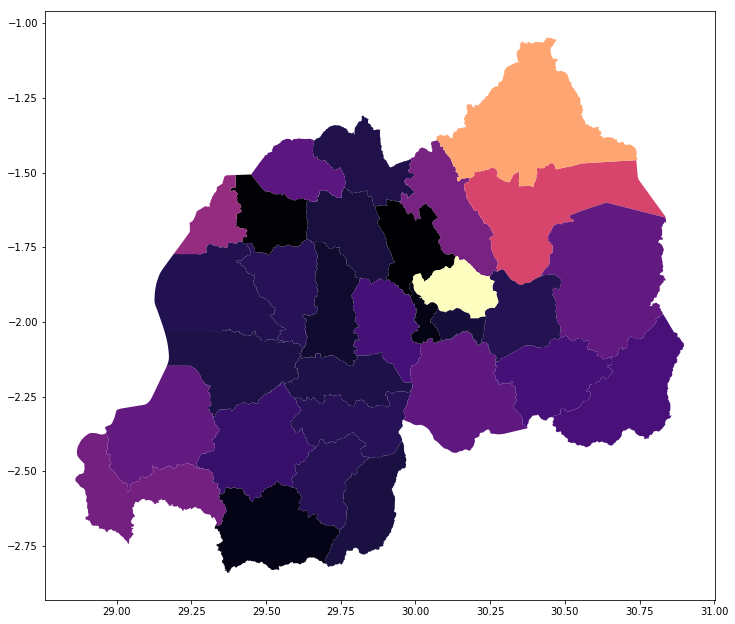

In [11]:
rwa_admin_2.plot(column='hrsl_pop', cmap=plt.cm.magma)

# Load World Pop Births

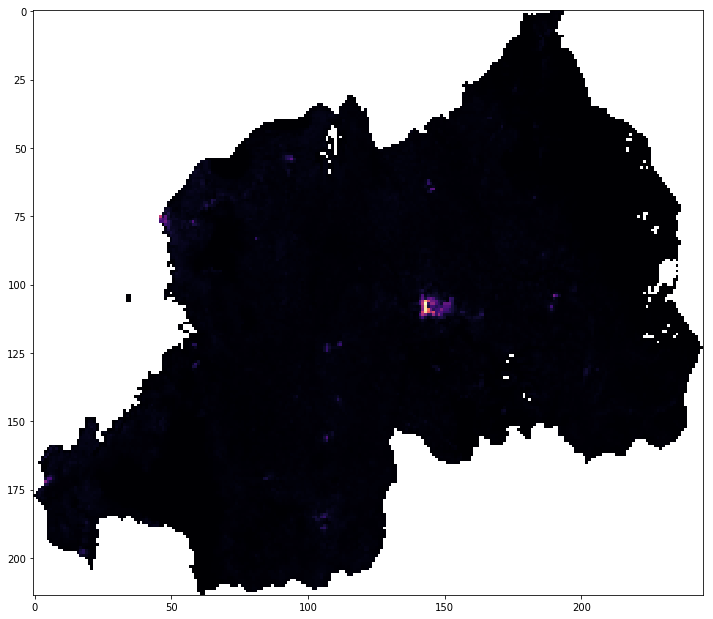

In [12]:
# rwa_worldpop_births_path = str(Path("/Users/bull/Downloads/Rwanda 1km births/RWA_births_pp_v2_2015.tif"))
rwa_worldpop_births_path = str(Path("../data/external/WorldPop/Rwanda 1km births/RWA_births_pp_v2_2015.tif"))

rst = rio.open(rwa_worldpop_births_path)
rio_plot.show(rst, cmap=plt.cm.magma)

/Users/bull/anaconda3/envs/subnational-vaccines/lib/python3.6/site-packages/rasterstats/main.py:145: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  with Raster(raster, affine, nodata, band) as rast:
/Users/bull/anaconda3/envs/subnational-vaccines/lib/python3.6/site-packages/rasterstats/io.py:242: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  self.affine = guard_transform(self.src.transform)
/Users/bull/anaconda3/envs/subnational-vaccines/lib/python3.6/site-packages/rasterstats/main.py:165: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  np.issubdtype(fsrc.array.dtype, float)
/Users/bull/anaconda3/envs/subnational-vaccines/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is try

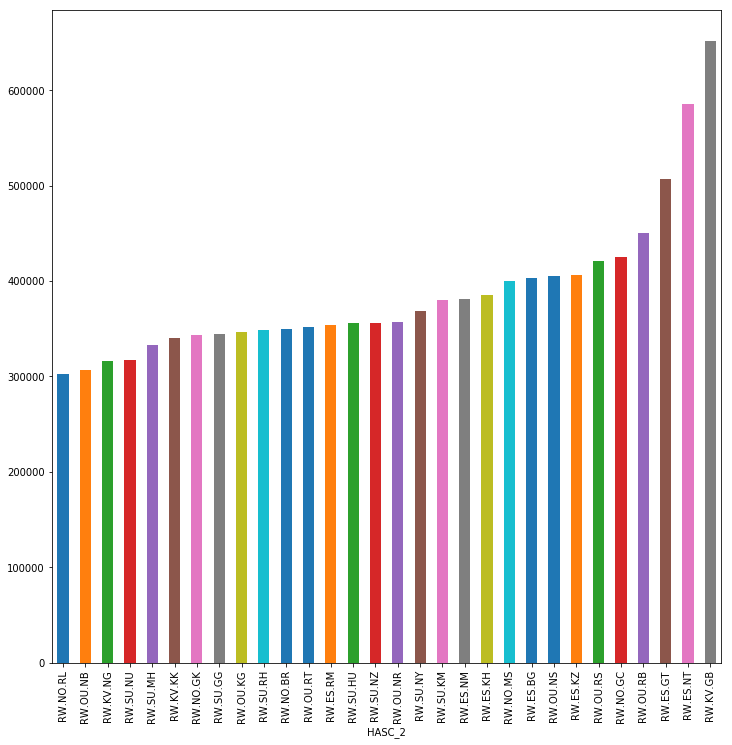

In [10]:
pop_list = rs.zonal_stats(rwa_admin_2, rwa_worldpop_births_path, stats='sum')
rwa_admin_2['worldpop_births'] = [x['sum'] for x in pop_list]

(rwa_admin_2.set_index('HASC_2')
            .hrsl_pop
            .sort_values()
            .plot(kind='bar'))

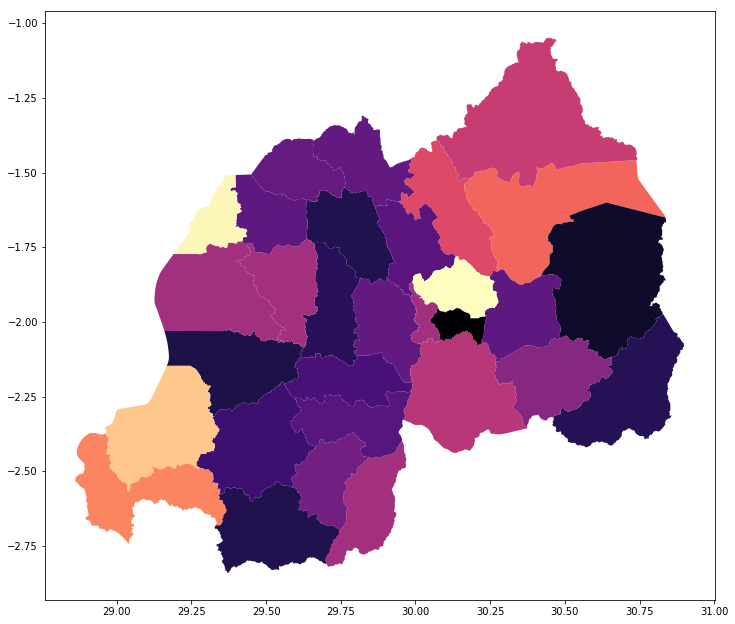

In [24]:
rwa_admin_2.plot(column='worldpop_births', cmap=plt.cm.magma)

### Load WHO data

In [12]:
who_df = pd.read_csv(Path("../data/interim/calc_cols_added.csv"), index_col=0)

who_rwa = who_df[who_df['Iso Code'] == 'RWA']
who_rwa.head(2)

Iso Code Country Name WHO Region  Year Vaccine Type Admin1  \
133606      RWA       Rwanda       AFRO  2016      HepB_BD   East   
133607      RWA       Rwanda       AFRO  2016          BCG   East   

                   Admin2  DenomType  Denominator  Numerator    Coverage  \
133606  Bugesera District        1.0      12209.0        NaN         NaN   
133607  Bugesera District        1.0      12209.0        NaN  125.451701   

        recalc_numerator           available_admin normalized_country  \
133606               NaN  East - Bugesera District             rwanda   
133607      15316.398164  East - Bugesera District             rwanda   

        indicator group  vaccine     timing  
133606          1  HepB  HepB_BD  1st_birth  
133607          1   BCG      BCG  1st_birth

### Estimate population with WHO data

 - Get denominator for each region
 - Multiply by the crude birth rate (https://data.worldbank.org/indicator/SP.DYN.CBRT.IN)
 - Remove " Distrct" from names
 - Plot estimates

In [13]:
who_rwa_births = (who_rwa[who_rwa.DenomType == 1]
                         .groupby('Admin2')
                         .Denominator
                         .first())

who_rwa_pops = who_rwa_births.multiply(1000 / 32)  # crude birth rate for rwanda

# index to names that will match admin2
who_rwa_births.index = who_rwa_births.index.str.strip(" District")
who_rwa_births.name = 'who_reported_births'

who_rwa_pops.index = who_rwa_pops.index.str.strip(" District")
who_rwa_pops.name = 'who_pop_estimate'

who_rwa_pops

Admin2
Bugesera      381531.25
Burera        354812.50
Gakenke       356562.50
Gasabo        558218.75
Gatsibo       456500.00
Gicumb        417031.25
Gisagara      339968.75
Huye          346187.50
Kamony        358937.50
Karong        349750.00
Kayonza       362781.25
Kicukiro      335781.25
Kirehe        358812.50
Muhanga       336406.25
Musanze       388218.75
Ngoma         355187.50
Ngororero     351781.25
Nyabihu       310687.50
Nyagatare     491062.50
Nyamagabe     360000.00
Nyamasheke    402500.00
Nyanza        341250.00
Nyarugenge    299968.75
Nyaruguru     310281.25
Rubavu        425531.25
Ruhango       337187.50
Rulindo       303250.00
Rusiz         422593.75
Rutsiro       342250.00
Rwamagana     330406.25
Name: who_pop_estimate, dtype: float64

/Users/bull/anaconda3/envs/subnational-vaccines/lib/python3.6/site-packages/matplotlib/colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


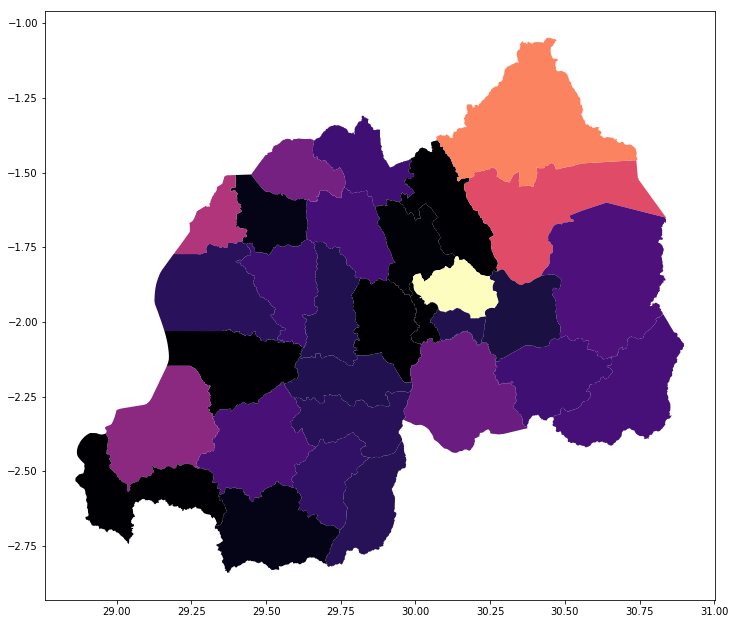

In [25]:
(rwa_admin_2.set_index('NAME_2')
            .join(who_rwa_pops)
            .plot(column='who_pop_estimate', cmap=plt.cm.magma))

/Users/bull/anaconda3/envs/subnational-vaccines/lib/python3.6/site-packages/matplotlib/colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


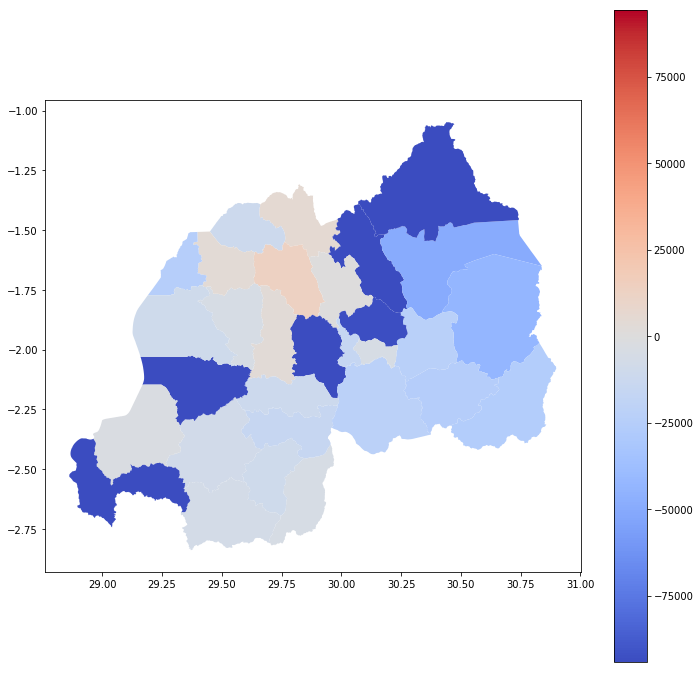

In [26]:
diff_data = (rwa_admin_2.set_index('NAME_2')
                        .join(who_rwa_pops)
                        .assign(who_diff=lambda x: x.who_pop_estimate - x.hrsl_pop))


diff_data.plot(column='who_diff',
               cmap=plt.cm.coolwarm,
               legend=True,
               vmin=-diff_data.who_diff.abs().max(),
               vmax=diff_data.who_diff.abs().max())

/Users/bull/anaconda3/envs/subnational-vaccines/lib/python3.6/site-packages/matplotlib/colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


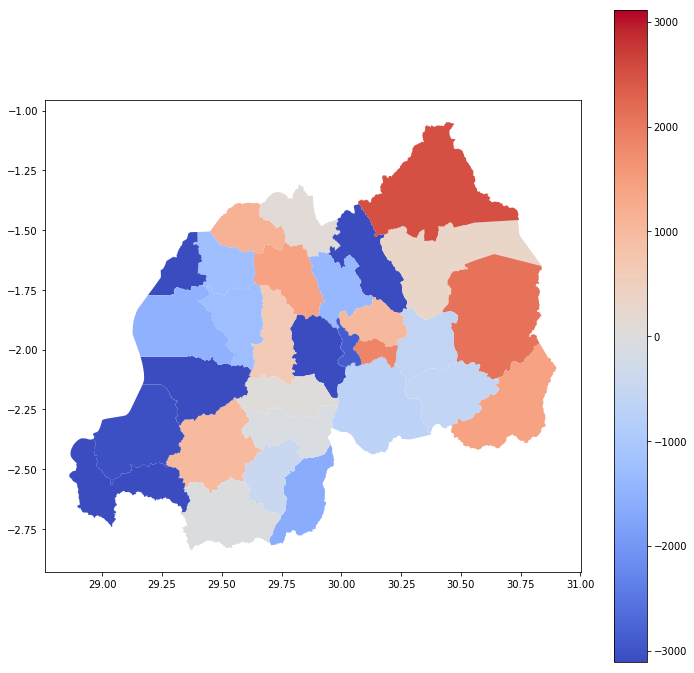

In [27]:
diff_data2 = (rwa_admin_2.set_index('NAME_2')
                        .join(who_rwa_births)
                        .assign(worldpop_diff=lambda x: x.who_reported_births - x.worldpop_births))


diff_data2.plot(column='worldpop_diff',
               cmap=plt.cm.coolwarm,
               legend=True,
               vmin=-diff_data2.worldpop_diff.abs().max(),
               vmax=diff_data2.worldpop_diff.abs().max())

# plt.colorbar(ax=ax)

In [33]:
a = rwa_admin_2.set_index('NAME_2').join(who_rwa_births)
a

OBJECTID  ID_0  ISO  NAME_0  ID_1            NAME_1  ID_2  \
NAME_2                                                                  
Burera         35505   189  RWA  Rwanda     1      Amajyaruguru     1   
Gakenke        35506   189  RWA  Rwanda     1      Amajyaruguru     2   
Gicumbi        35507   189  RWA  Rwanda     1      Amajyaruguru     3   
Musanze        35508   189  RWA  Rwanda     1      Amajyaruguru     4   
Rulindo        35509   189  RWA  Rwanda     1      Amajyaruguru     5   
Gisagara       35510   189  RWA  Rwanda     2         Amajyepfo     6   
Huye           35511   189  RWA  Rwanda     2         Amajyepfo     7   
Kamonyi        35512   189  RWA  Rwanda     2         Amajyepfo     8   
Muhanga        35513   189  RWA  Rwanda     2         Amajyepfo     9   
Nyamagabe      35514   189  RWA  Rwanda     2         Amajyepfo    10   
Nyanza         35515   189  RWA  Rwanda     2         Amajyepfo    11   
Nyaruguru      35516   189  RWA  Rwanda     2         Amajyepfo    12   
Ruhango        35517   189  RWA  Rwanda     2         Amajyepfo    13   
Bugesera       35518   189  RWA  Rwanda     3     Iburasirazuba    14   
Gatsibo        35519   189  RWA  Rwanda     3     Iburasirazuba    15   
Kayonza        35520   189  RWA  Rwanda     3     Iburasirazuba    16   
Kirehe         35521   189  RWA  Rwanda     3     Iburasirazuba    17   
Ngoma          35522   189  RWA  Rwanda     3     Iburasirazuba    18   
Nyagatare      35523   189  RWA  Rwanda     3     Iburasirazuba    19   
Rwamagana      35524   189  RWA  Rwanda     3     Iburasirazuba    20   
Karongi        35525   189  RWA  Rwanda     4    Iburengerazuba    21   
Ngororero      35526   189  RWA  Rwanda     4    Iburengerazuba    22   
Nyabihu        35527   189  RWA  Rwanda     4    Iburengerazuba    23   
Nyamasheke     35528   189  RWA  Rwanda     4    Iburengerazuba    24   
Rubavu         35529   189  RWA  Rwanda     4    Iburengerazuba    25   
Rusizi         35530   189  RWA  Rwanda     4    Iburengerazuba    26   
Rutsiro        35531   189  RWA  Rwanda     4    Iburengerazuba    27   
Gasabo         35532   189  RWA  Rwanda     5  Umujyi wa Kigali    28   
Kicukiro       35533   189  RWA  Rwanda     5  Umujyi wa Kigali    29   
Nyarugenge     35534   189  RWA  Rwanda     5  Umujyi wa Kigali    30   

              HASC_2  CCN_2 CCA_2    TYPE_2 ENGTYPE_2 NL_NAME_2 VARNAME_2  \
NAME_2                                                                      
Burera      RW.NO.BR     44    44  District  District                       
Gakenke     RW.NO.GK     42    42  District  District                       
Gicumbi     RW.NO.GC     45    45  District  District                       
Musanze     RW.NO.MS     43    43  District  District                       
Rulindo     RW.NO.RL     41    41  District  District                       
Gisagara    RW.SU.GG     22    22  District  District                       
Huye        RW.SU.HU     24    24  District  District                       
Kamonyi     RW.SU.KM     28    28  District  District                       
Muhanga     RW.SU.MH     27    27  District  District                       
Nyamagabe   RW.SU.NY     25    25  District  District                       
Nyanza      RW.SU.NZ     21    21  District  District                       
Nyaruguru   RW.SU.NU     23    23  District  District                       
Ruhango     RW.SU.RH     26    26  District  District                       
Bugesera    RW.ES.BG     57    57  District  District                       
Gatsibo     RW.ES.GT     53    53  District  District                       
Kayonza     RW.ES.KZ     54    54  District  District                       
Kirehe      RW.ES.KH     55    55  District  District                       
Ngoma       RW.ES.NM     56    56  District  District                       
Nyagatare   RW.ES.NT     52    52  District  District                       
Rwamagana   RW.ES.RM     51    51  District  District     